following https://lifetimes.readthedocs.io/en/latest/Quickstart.html#estimating-customer-lifetime-value-using-the-gamma-gamma-model

beta geometric negative binomial distribution
Counting Your Customers the Easy Way: An Alternative to the Pareto/NBD Model
Peter S. Fader
Bruce G.S.Hardie
Ka Lok Lee
2003
http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf

as opposed to Pareto/NBD, which assumes Poisson distributed purchases with a Gamma prior and exponentially distributed customer lifetimes with a Gamma prior

dataset available at https://www.kaggle.com/blastchar/telco-customer-churn/data#

we need a dataset that summarizes customers by their lifetime (age; time since first purchase), frequency (number of purchases), and monetary value (average value per purchase). The lifetime package provides a utility function for this: summary_data_from_transaction_data.

In [2]:
#!pip install lifetimes

In [3]:
from lifetimes.datasets import load_cdnow_summary, load_cdnow_summary_data_with_monetary_value

In [4]:
data = load_cdnow_summary_data_with_monetary_value()

In [5]:
len(data)

2357

In [6]:
(data.frequency>0).sum()

946

In [7]:
data.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00


The dataset is explained in the lifetimes documentation:
    
https://lifetimes.readthedocs.io/en/latest/Quickstart.html#estimating-customer-lifetime-value-using-the-gamma-gamma-model
    
* frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
* T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
* recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
* monetary_value represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.


In [153]:
data.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00


In [53]:
data.groupby(by='customer_id').count().mean()

frequency         1.0
recency           1.0
T                 1.0
monetary_value    1.0
dtype: float64

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

(0, 20)

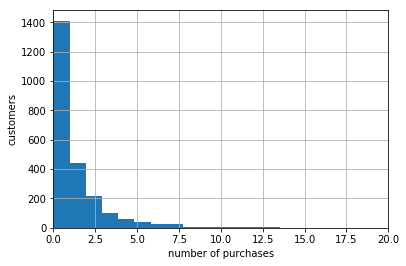

In [11]:
fig = data.frequency.hist(bins=30)
plt.ylabel('customers')
plt.xlabel('number of purchases')
plt.xlim(left=0, right=20)

In [12]:
data.frequency.mean()

1.0424268137462878

In [13]:
data.mean()

frequency          1.042427
recency            6.845787
T                 32.715829
monetary_value    14.079045
dtype: float64

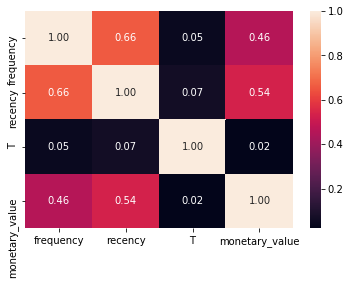

In [14]:
from dython.nominal import associations
associations(data)

In [130]:
import scipy

scipy.stats.spearmanr(data.recency, data.monetary_value)

SpearmanrResult(correlation=0.9280848765775312, pvalue=0.0)

In [129]:
scipy.stats.spearmanr(data.recency, data.monetary_value * data.frequency)

SpearmanrResult(correlation=0.9520950252874786, pvalue=0.0)

In [116]:
scipy.stats.spearmanr(data.recency, data.monetary_value)

SpearmanrResult(correlation=0.9280848765775312, pvalue=0.0)

CDNOW data presented in Fader et al. 2005
Fader, Peter S., Bruce G. S. Hardie, and Ka Lok Lee (2005), “RFM and CLV: Using Iso-value Curves for Customer Base Analysis,”Journal of MarketingResearch,42(November), 415–430

In [ ]:
Pete Fader's publications
https://scholar.google.com/citations?user=NYOYpwQAAAAJ

In [ ]:
https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GammaGamma

[1]: Peter S. Fader, Bruce G. S. Hardi. The Gamma-Gamma Model of Monetary Value. Technical Report, 2013. http://www.brucehardie.com/notes/025/gamma_gamma.pdf

[2]: Michael Figurnov, Shakir Mohamed, Andriy Mnih. Implicit Reparameterization Gradients. arXiv preprint arXiv:1805.08498, 2018. https://arxiv.org/abs/1805.08498

In [15]:
from lifetimes import GammaGammaFitter, BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])


<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>

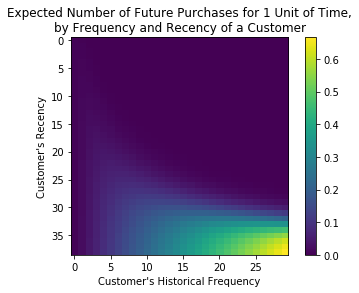

In [16]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

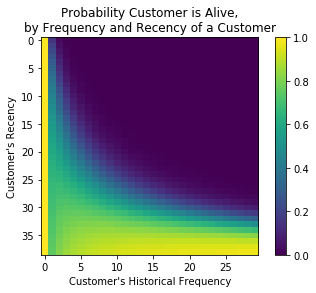

In [17]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)


In [21]:
data_repeat = data[data.frequency>0]

In [22]:
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(data_repeat.frequency, data_repeat.monetary_value)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [100]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64


In [103]:
print('Expected conditional average profit: %s, Average profit: %s' % (
    ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).mean(),
    data[data['frequency']>0]['monetary_value'].mean()
))


Expected conditional average profit: 35.25295817605011, Average profit: 35.07855179704026


In [104]:
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))


customer_id
1      140.096218
2       18.943466
3       38.180575
4       38.180575
5       38.180575
6     1003.868285
7       28.109681
8       38.180575
9      167.418224
10      38.180575
Name: clv, dtype: float64


very similar dataset: online retail at https://www.kaggle.com/blastchar/telco-customer-churn/data#
also available at http://archive.ics.uci.edu/ml/datasets/Online+Retail

you can see a model comparison at https://github.com/GoogleCloudPlatform/tensorflow-lifetime-value
    
* lifetimes
* tensorflow neural network
* automl
